**Imports**

In [ ]:
import json
from pprint import pprint
import pandas as pd
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from pathlib import Path

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Constructing the basic dataset

In [ ]:
data_folder = Path('../data/twint')
tweets_file = data_folder / 'data.txt'

In [ ]:
f = open(tweets_file, 'r')
lines = [l for l in f]
f.close()

In [ ]:
tweets = [json.loads(l) for l in lines]
print(tweets[0])

In [ ]:
print('Number of tweets:\t%s' % len(tweets))

## Top 20 Hashtags

In [ ]:
hashtags = [h for t in tweets for h in t['hashtags']]

In [461]:
from collections import Counter
hashtags_count = pd.DataFrame.from_dict(Counter(hashtags), orient='index', columns=['count']).sort_values(by='count', ascending=False)[:20]
hashtags_count

,count
#uber,38685
#lyft,15161
#uberlyftstrike,3738
#uberipo,3347
#taxi,2469
#ipo,2454
#rideshare,1582
#uk,1556
#tfl,1510
#uberstrike,1429


## Tweet Time Distribution

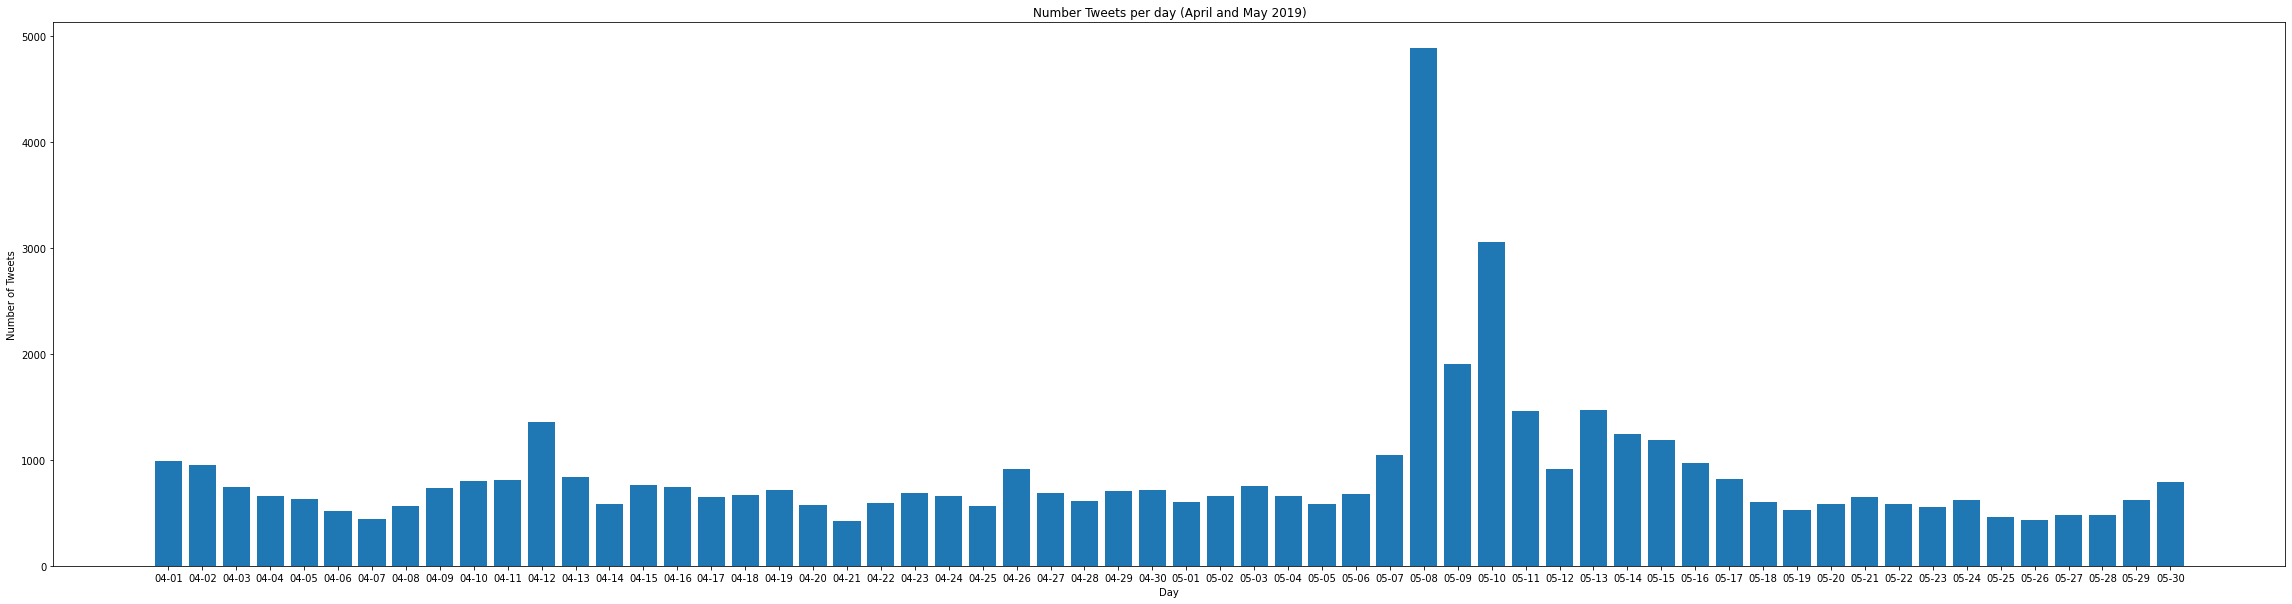

In [462]:
dates_to_n_tweets = {}

for t in tweets:
    date = t['date'].split('-')[1] + '-' + t['date'].split('-')[2]
    try:
        dates_to_n_tweets[date] = dates_to_n_tweets[date] + 1
    except:
        dates_to_n_tweets[date] = 0

sorted_dates = sorted(dates_to_n_tweets.items())
plt.figure(1, figsize=(40, 10))
plt.bar([e[0] for e in sorted_dates], [e[1] for e in sorted_dates])
plt.title('Number Tweets per day (April and May 2019)')
plt.xlabel('Day')
plt.ylabel('Number of Tweets')
plt.show()

# Text preparation

In [463]:
stop_words = stopwords.words('english')
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [492]:
def word_tokenize(tweet):
    return tokenizer.tokenize(tweet)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_tweet_text(tweet):
    
    tweet = tweet.lower()
    #Remove numbers
    tweet = re.sub(r"[0-9]", '', tweet, flags=re.MULTILINE)
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tweet_tokens = word_tokenize(tweet)
    # Remove non-alpha words
    filtered_words = [w for w in tweet_tokens if w.isalpha()]
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    stemmed = [stemmer.stem(w) for w in filtered_words]
    
    # Filter out short lemmas
    stemmed = [w for w in stemmed if len(w) > 2]
    
    return stemmed

In [553]:
unique_usernames = {t['username'] for t in tweets}
users_to_documents = {u:[] for u in unique_usernames}

for tw in tweets:
    u = tw['username']
    t = preprocess_tweet_text(tw['tweet'])
    users_to_documents[u] = users_to_documents[u] + t

print(list(users_to_documents.items())[200])

('funeral_preplan', ['best', 'dress', 'uber', 'uber', 'uberdriv', 'ubereat', 'suit', 'moor', 'hoverboard', 'hoverboardfail', 'toooldforthi', 'fun', 'fast', 'windinmyhair', 'hamilton', 'ontario'])


## See document length distribution

In [554]:
lengths = {u:len(doc) for (u, doc) in users_to_documents.items()}
min = np.min(list(lengths.values()))
max = np.max(list(lengths.values()))
bins = np.linspace(start=min, stop=max, num=200, endpoint=True)

labels = list(range(199))

lengths_df = pd.DataFrame({'Doc': list(lengths.keys()), 'Length': list(lengths.values())})

s = pd.cut(lengths_df['Length'], bins=bins).value_counts()

s.head()

(1.0, 89.884]         24229
(89.884, 178.769]       478
(178.769, 267.653]      111
(267.653, 356.538]       76
(356.538, 445.422]       25
Name: Length, dtype: int64

## Filter out any users that now have less than 150 tokens

In [555]:
print(len(users_to_documents.values()))
users_to_documents = {u:doc for (u, doc) in users_to_documents.items() if len(doc) >= 150}
print(len(users_to_documents.values()))

25040
400


## Filter out any users with a very low token variety

In [556]:
def lexical_diversity_percentage(tokens):
    return len(set(tokens)) / len(tokens) * 100

### Token variety histogram

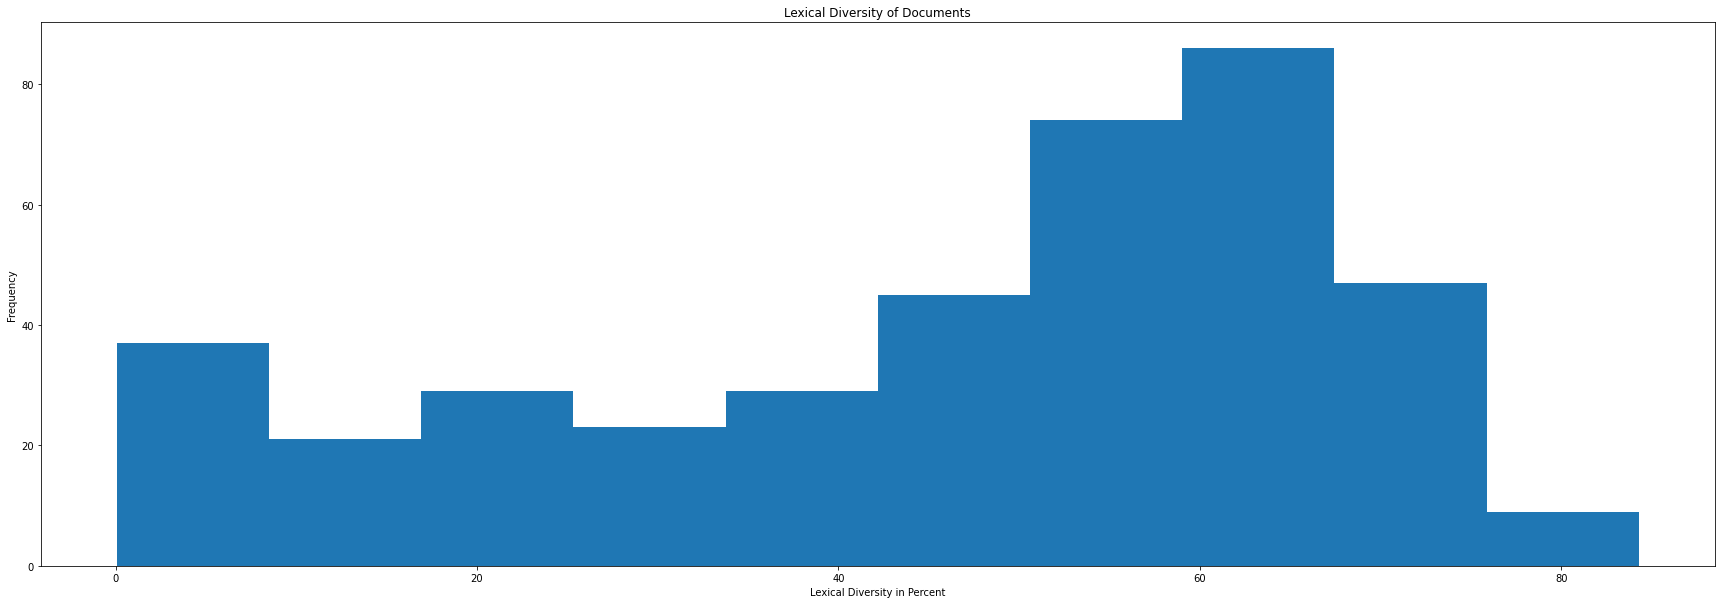

In [557]:
lexical_diversities = {u:lexical_diversity_percentage(doc) for (u, doc) in users_to_documents.items()}
lexical_div_df = pd.DataFrame.from_dict(lexical_diversities, orient='index', columns=['diversity'])
lexical_div_df.groupby('diversity')
plt.figure(1, figsize=(30, 10))
plt.title('Lexical Diversity of Documents')
plt.xlabel('Lexical Diversity in Percent')
lexical_div_df['diversity'].plot(kind='hist')

In [558]:
print(len(users_to_documents))
users_to_documents = {u:doc for (u, doc) in users_to_documents.items() if lexical_diversity_percentage(doc) >= 40}
len(users_to_documents)

400


270

In [559]:
users_to_documents_df = pd.DataFrame.from_dict(users_to_documents, orient='index')
users_to_documents_df

,0,1,2,3,4,5,6,7,8,9,...,2399,2400,2401,2402,2403,2404,2405,2406,2407,2408
doctorlavant,interest,uber,pac,name,offlin,edit,idk,pic,offlin,okay,...,None,None,None,None,None,None,None,None,None,None
malicodes,dont,call,uber,may,uberstrik,higherup,uber,know,exactli,theyr,...,None,None,None,None,None,None,None,None,None,None
lyftfans,help,dayton,tornado,aftermath,lyft,rideshar,free,pictwittercomupedkev,year,carbon,...,None,None,None,None,None,None,None,None,None,None
oneuiux,lyft,add,inapp,pronoun,choic,rider,worldcupquiz,cricket,dream,cricketmerijaan,...,None,None,None,None,None,None,None,None,None,None
bobhays_,asklyft,hey,statu,lyft,driver,app,document,updat,app,keep,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
market_screener,lyft,uber,share,fall,second,day,illfat,ipo,lyft,follow,...,None,None,None,None,None,None,None,None,None,None
theoldrepublic,invest,pinterest,pin,work,pretti,well,pass,lyft,took,chanc,...,None,None,None,None,None,None,None,None,None,None
kasdad,absolut,valu,cnbc,uber,ipo,spx,ndx,iwm,nice,man,...,None,None,None,None,None,None,None,None,None,None
maximillian_alv,talk,disabl,healthcar,activist,flyingfanni,workingpod,week,royal,fuck,isand,...,None,None,None,None,None,None,None,None,None,None


# Constructing the Term/Document Matrix

In [560]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [561]:
docs = users_to_documents.values()

In [664]:
def do_nothing(tokens):
    return tokens

vectorizer = TfidfVectorizer(lowercase=False, tokenizer=do_nothing, min_df=0.25)

X = vectorizer.fit_transform(docs)

In [665]:
tf_idf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [666]:
tf_idf_df

,also,app,billion,busi,call,car,citi,come,compani,could,...,trade,uber,uberipo,use,want,way,week,work,would,year
0,0.000000,0.000000,0.000000,0.000000,0.252025,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.862983,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.104043,0.000000,0.000000,0.000000,0.103410,0.000000,0.000000,0.000000,0.067364,0.000000,...,0.000000,0.442621,0.0,0.000000,0.090458,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.030679,0.000000,0.015780,0.019531,0.000000,0.000000,0.034346,0.000000,0.017538,...,0.018958,0.066877,0.0,0.017084,0.000000,0.018633,0.000000,0.000000,0.017263,0.015557
3,0.000000,0.085182,0.000000,0.000000,0.000000,0.160574,0.105278,0.000000,0.000000,0.000000,...,0.000000,0.557066,0.0,0.000000,0.094872,0.000000,0.104667,0.000000,0.000000,0.000000
4,0.000000,0.387509,0.000000,0.039864,0.098678,0.000000,0.000000,0.000000,0.064282,0.000000,...,0.000000,0.021118,0.0,0.000000,0.000000,0.047071,0.142846,0.084146,0.130830,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.000000,0.000000,0.128345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.050907,0.134684,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
266,0.066257,0.000000,0.053721,0.452266,0.000000,0.000000,0.000000,0.028953,0.000000,0.088703,...,0.031962,0.239591,0.0,0.000000,0.086409,0.062826,0.000000,0.028078,0.029104,0.052455
267,0.000000,0.000000,0.076518,0.075787,0.093800,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.091051,0.642381,0.0,0.000000,0.000000,0.089488,0.090523,0.079986,0.000000,0.000000
268,0.268382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.342528,0.0,0.116670,0.116670,0.000000,0.128715,0.113733,0.000000,0.000000


## Performing a PCA

In [667]:
from sklearn import preprocessing
data_scaled = pd.DataFrame(preprocessing.normalize(tf_idf_df), columns=tf_idf_df.columns)
data_scaled

,also,app,billion,busi,call,car,citi,come,compani,could,...,trade,uber,uberipo,use,want,way,week,work,would,year
0,0.000000,0.000000,0.000000,0.000000,0.252025,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.862983,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.104043,0.000000,0.000000,0.000000,0.103410,0.000000,0.000000,0.000000,0.067364,0.000000,...,0.000000,0.442621,0.0,0.000000,0.090458,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.030679,0.000000,0.015780,0.019531,0.000000,0.000000,0.034346,0.000000,0.017538,...,0.018958,0.066877,0.0,0.017084,0.000000,0.018633,0.000000,0.000000,0.017263,0.015557
3,0.000000,0.085182,0.000000,0.000000,0.000000,0.160574,0.105278,0.000000,0.000000,0.000000,...,0.000000,0.557066,0.0,0.000000,0.094872,0.000000,0.104667,0.000000,0.000000,0.000000
4,0.000000,0.387509,0.000000,0.039864,0.098678,0.000000,0.000000,0.000000,0.064282,0.000000,...,0.000000,0.021118,0.0,0.000000,0.000000,0.047071,0.142846,0.084146,0.130830,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.000000,0.000000,0.128345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.050907,0.134684,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
266,0.066257,0.000000,0.053721,0.452266,0.000000,0.000000,0.000000,0.028953,0.000000,0.088703,...,0.031962,0.239591,0.0,0.000000,0.086409,0.062826,0.000000,0.028078,0.029104,0.052455
267,0.000000,0.000000,0.076518,0.075787,0.093800,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.091051,0.642381,0.0,0.000000,0.000000,0.089488,0.090523,0.079986,0.000000,0.000000
268,0.268382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.342528,0.0,0.116670,0.116670,0.000000,0.128715,0.113733,0.000000,0.000000


## Perform the PCA

In [668]:
pca = PCA(n_components=20)
X_reduced = pca.fit_transform(data_scaled)

In [669]:
len(X_reduced[:, 0])

270

## Analyze the percentage of explained variance per principal component

In [670]:
pd.DataFrame(pca.explained_variance_ratio_)

,0
0,0.126682
1,0.111464
2,0.093087
3,0.054631
4,0.049320
5,0.040533
6,0.030366
7,0.027250
8,0.023677
9,0.022273


In [671]:
explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the PCA step: {}%".format(int(explained_variance * 100)))
print()

Explained variance of the PCA step: 73%



## 2D Plot

Text(0.5, 1.0, '2D Plot')

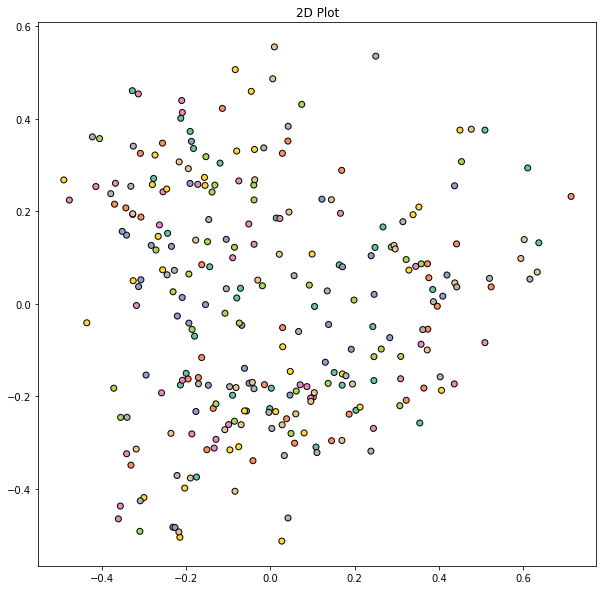

In [672]:
y = range(0, len(X_reduced))
plt.figure(1, figsize=(10, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap=plt.cm.Set2, edgecolor='k')
plt.title('2D Plot')

## 3D Plot

Text(0.5, 0.92, 'PCA 3D Plot')

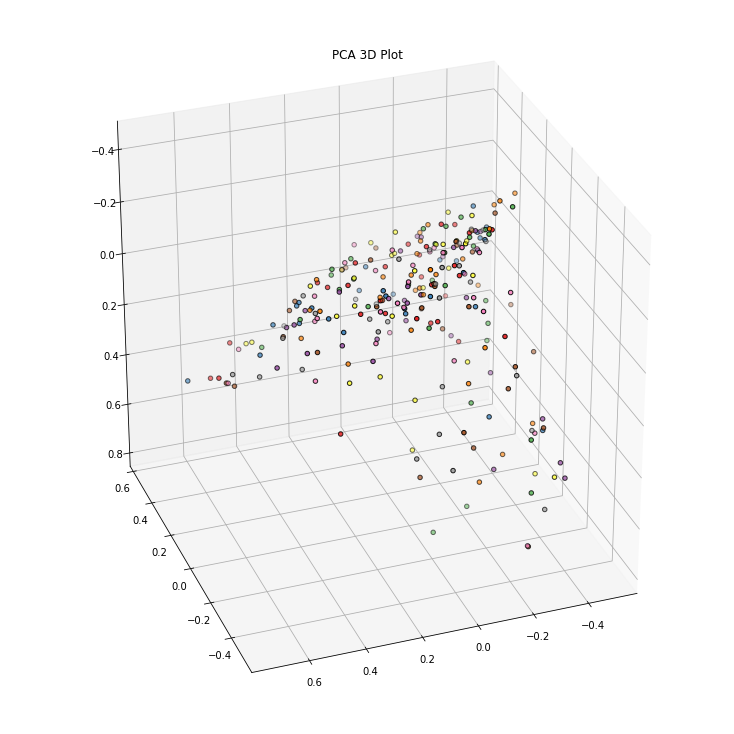

In [673]:
fig = plt.figure(1, figsize=(10, 10))
ax = Axes3D(fig, elev=-150, azim=110)
y = range(0, len(X_reduced))
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k')
ax.set_title("PCA 3D Plot")

## See the documents/users with highest MSE

In [674]:
inverse_transform_data = pca.inverse_transform(X_reduced)
MSE_score = ((data_scaled-inverse_transform_data)**2).sum(axis=1)

In [675]:
MSE_max_scores = list(MSE_score.nlargest(10).index)

In [676]:
docs_with_highest_mse_df = users_to_documents_df.iloc[MSE_max_scores]
docs_with_highest_mse_df

,0,1,2,3,4,5,6,7,8,9,...,2399,2400,2401,2402,2403,2404,2405,2406,2407,2408
walkinginaustin,drama,show,vet,annual,drama,visit,thank,lyft,pictwittercomuakzxwxyl,stress,...,None,None,None,None,None,None,None,None,None,None
crushthemarket,would,though,lose,tonn,cash,chanc,profit,actual,matter,market,...,None,None,None,None,None,None,None,None,None,None
govithinks,uber,biggest,tech,ipo,sinc,facebook,may,big,differ,origin,...,None,None,None,None,None,None,None,None,None,None
mr_halford,work,usual,holiday,uberlyft,work,head,back,great,airbnb,baltimor,...,None,None,None,None,None,None,None,None,None,None
adriancroydon,anyon,say,uber,safe,must,peculiar,childhood,polic,expens,unnessari,...,None,None,None,None,None,None,None,None,None,None
postmatedriver,ouch,uber,pictwittercomvjmumwald,pull,way,stop,offset,intersect,fuck,uber,...,None,None,None,None,None,None,None,None,None,None
jjrodv,today,support,uberlyftstrik,push,neoliber,exploit,facet,mani,name,uberlyftstrik,...,None,None,None,None,None,None,None,None,None,None
mondiablue,dude,ask,make,extra,stop,give,star,rate,peak,gig,...,None,None,None,None,None,None,None,None,None,None
_algocapital,britain,capit,key,market,uber,home,million,user,driver,presenc,...,None,None,None,None,None,None,None,None,None,None
tedinjest,saw,crazi,video,morn,lyft,driver,get,punch,head,repeatedli,...,None,None,None,None,None,None,None,None,None,None


### See the length of the documents/users with highest MSE

In [677]:
usernames_with_highest_mse = list(docs_with_highest_mse_df.index)
lengths_of_docs_with_highest_mse_df = pd.DataFrame.from_dict({u:len(users_to_documents[u]) for u in usernames_with_highest_mse}, orient='index', columns=['count']).sort_values(by='count', ascending=False)
lengths_of_docs_with_highest_mse_df

,count
adriancroydon,317
mr_halford,260
jjrodv,244
mondiablue,223
_algocapital,219
crushthemarket,207
walkinginaustin,186
postmatedriver,186
tedinjest,178
govithinks,170


## See the documents/users with the lowest MSE

In [678]:
MSE_low_scores = list(MSE_score.nsmallest(10).index)

In [679]:
docs_with_lowest_mse_df = users_to_documents_df.iloc[MSE_low_scores]
docs_with_lowest_mse_df

,0,1,2,3,4,5,6,7,8,9,...,2399,2400,2401,2402,2403,2404,2405,2406,2407,2408
lyftfans,help,dayton,tornado,aftermath,lyft,rideshar,free,pictwittercomupedkev,year,carbon,...,None,None,None,None,None,None,None,None,None,None
frankbullitt39,woman,uber,male,taxi,driver,grope,breast,leed,uberipo,safetyneverstop,...,None,None,None,None,None,None,None,None,None,None
gurdipsahota,lobbi,uber,bcpoli,bcleg,vanpoli,ridehail,rideshar,uber,lyft,bcndp,...,None,None,None,None,None,None,None,None,None,None
rmawaters,amazon,invest,deliveroo,rival,uber,food,deliveri,amazon,uber,promis,...,None,None,None,None,None,None,None,None,None,None
dnabrandsinc,uber,price,ipo,toward,low,end,state,rang,via,yahoofin,...,None,None,None,None,None,None,None,None,None,None
kalldriver,toilet,rideshar,new,thing,studi,claim,rideshar,car,dirtier,toilet,...,None,None,None,None,None,None,None,None,None,None
hacker_news_hir,uber,start,deactiv,rider,low,rate,uber,comment,price,fix,...,None,None,None,None,None,None,None,None,None,None
ptr_hill,gujarat,transport,depart,recent,submit,draft,propos,restrict,total,number,...,None,None,None,None,None,None,None,None,None,None
dignitydriver,dkho,big,babi,uber,pictwittercomivvygjsmj,got,limit,twitter,attack,uber,...,new,time,low,quest,bonu,uber,dkho,fornic,uber,pictwittercomqmlgcvwsz
hamish_ash,gujarat,transport,depart,recent,submit,draft,propos,restrict,total,number,...,None,None,None,None,None,None,None,None,None,None


### See the length of the documents/users with lowest MSE

In [680]:
usernames_with_lowest_mse = list(docs_with_lowest_mse_df.index)
lengths_of_docs_with_lowest_mse_df = pd.DataFrame.from_dict({u:len(users_to_documents[u]) for u in usernames_with_lowest_mse}, orient='index', columns=['count']).sort_values(by='count', ascending=False)
lengths_of_docs_with_lowest_mse_df

,count
dignitydriver,2409
frankbullitt39,1082
lyftfans,495
gurdipsahota,409
hacker_news_hir,295
dnabrandsinc,269
ptr_hill,185
rmawaters,173
kalldriver,166
hamish_ash,153


In [681]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important_feature_indexes_per_pc = {}

initial_feature_names = data_scaled.columns

dfs = []

for pc in range(n_pcs):
    components_enumerated = list(enumerate(pca.components_[pc]))
    components_sorted = sorted(components_enumerated, key=lambda x:np.abs(x[1]), reverse=True)
    features_imps = {initial_feature_names[i]:imp for (i, imp) in components_sorted}
    features_imps_df = pd.DataFrame.from_dict(features_imps, orient='index', columns = ['importance'] )[:20]
    dfs.append(features_imps_df)
    
i = 1
for df in dfs:
    print('PCA %d' % i)
    print(df)
    print('')
    i += 1

PCA 1
          importance
lyft        0.486883
ipo        -0.422603
uber       -0.419880
uberipo    -0.301487
driver      0.300596
rideshar    0.211780
ride        0.131149
market     -0.104214
share      -0.102498
billion    -0.098411
price      -0.092565
stock      -0.091962
get         0.091444
invest     -0.087621
strike      0.086735
public     -0.083752
drive       0.082022
car         0.081841
work        0.080841
trade      -0.073124

PCA 2
          importance
ipo         0.510934
lyft        0.489558
uberipo    -0.446116
driver     -0.321492
stock       0.187689
rideshar    0.168106
uber       -0.107246
know       -0.093908
market      0.087829
billion     0.086472
invest      0.078065
passeng    -0.075455
pay        -0.074265
price       0.073636
taxi       -0.071330
trade       0.069111
dont       -0.061984
investor    0.061930
drive      -0.059736
get        -0.056943

PCA 3
          importance
uberipo     0.731180
uber       -0.566199
lyft        0.244083
driver     -0.

# Clustering

In [682]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import Normalizer

In [683]:
normalizer = Normalizer(copy=False)
X_reduced_normalized = normalizer.fit_transform(X_reduced)
km = KMeans(n_clusters=4)
distances = km.fit_transform(X_reduced_normalized)

## Plotting the clusters

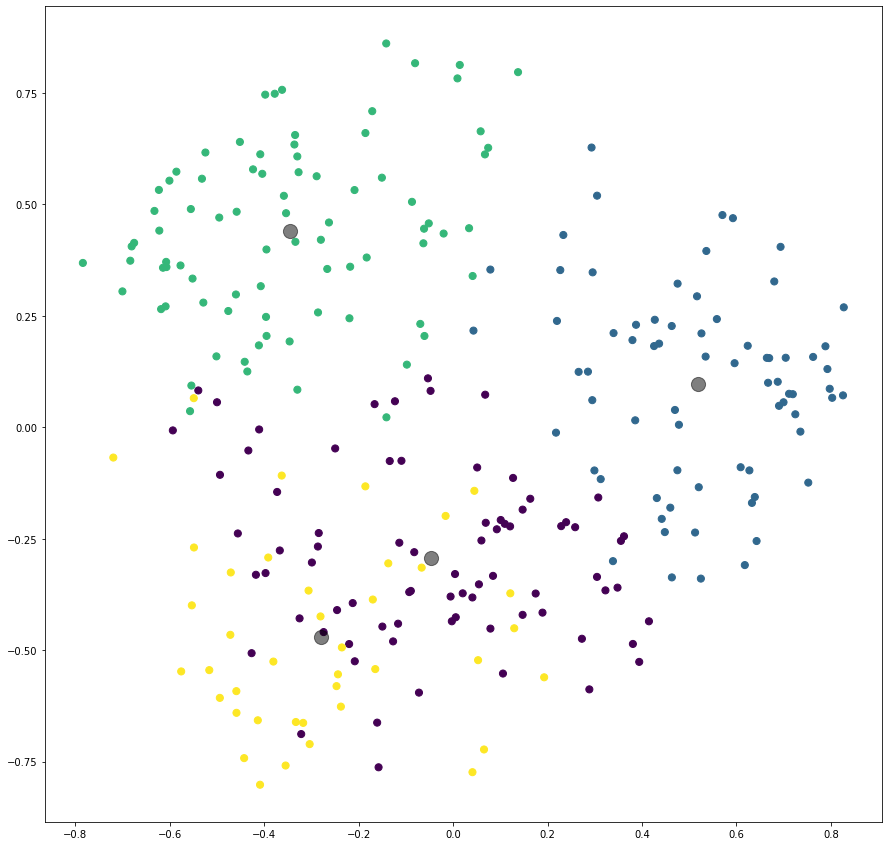

In [684]:
y_kmeans = km.labels_
plt.figure(figsize=(15, 15))
plt.scatter(X_reduced_normalized[:, 0], X_reduced_normalized[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [685]:
original_space_centroids = pca.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(4):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        print()

Cluster 0: uber
 driver
 app
 taxi
 know
 like
 drive
 ride
 get
 car
Cluster 1: lyft
 uber
 driver
 rideshar
 ride
 get
 car
 drive
 strike
 work
Cluster 2: uber
 ipo
 lyft
 stock
 price
 billion
 market
 share
 public
 compani
Cluster 3: uberipo
 uber
 driver
 share
 ipo
 compani
 investor
 profit
 get
 price


## Get the users per cluster

In [686]:
cluster_df = pd.DataFrame()
cluster_df['user'] = users_to_documents_df.index
cluster_df['cluster'] = km.labels_
cluster_df['distance_to_0'] = distances[:, 0]
cluster_df['distance_to_1'] = distances[:, 1]
cluster_df['distance_to_2'] = distances[:, 2]
cluster_df['distance_to_3'] = distances[:, 3]

In [687]:
# Cluster 0
users_cluster0 = cluster_df.loc[cluster_df['cluster'] == 0]
users_cluster0
# Cluster 1
users_cluster1 = cluster_df.loc[cluster_df['cluster'] == 1]
# Cluster 2
users_cluster2 = cluster_df.loc[cluster_df['cluster'] == 2]
# Cluster 3
users_cluster3 = cluster_df.loc[cluster_df['cluster'] == 3]

## Get the tweets per cluster

In [688]:
tweets_cluster0 = [t for t in tweets if t['username'] in list(users_cluster0['user'])]    
tweets_cluster1 = [t for t in tweets if t['username'] in list(users_cluster1['user'])]
tweets_cluster2 = [t for t in tweets if t['username'] in list(users_cluster2['user'])]
tweets_cluster3 = [t for t in tweets if t['username'] in list(users_cluster3['user'])]
texts_cluster0 = [t['tweet'] for t in tweets_cluster0]
texts_cluster1 = [t['tweet'] for t in tweets_cluster1]
texts_cluster2 = [t['tweet'] for t in tweets_cluster2]
texts_cluster3 = [t['tweet'] for t in tweets_cluster3]
print(texts_cluster1)

["#accidents happen. Make sure you're prepared when they do. We put together a step-by-step list to help you get the best possible outcome possible.  \n\n#Uber #Lyft #accident #injuries pic.twitter.com/TAhag5lFae", '"#Uber’s earnings report could give a clearer picture on self-driving cars"\n  https://www.digitaltrends.com/cars/ubers-self-driving-car-update-earnings-report/?amp&__twitter_impression=true\xa0…', '#UBER reports earnings. Good the short sellers are on vacation', "How #Uber Eats is Becoming Uber's Most Successful Service.\n\n https://buff.ly/2TQA4rh\xa0 pic.twitter.com/LueWNUcP9v", '@ClaytonGuse @nicolegelinas @nytwa @nyctaxinews I could have told you that, without a study being done on it! #Taxi #Uber  https://twitter.com/ClaytonGuse/status/1134076744028360704\xa0…', 'I say that to myself every night on the streets! #Uber #FUber', 'At the @CastletonSqMall about to head to a friend’s house; going to use @car_smartt instead of @Uber @lyft because it’s cheaper and pays driver